In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
pd.options.display.max_rows = 20
pd.options.display.max_colwidth = 200

import plotly

from hearthstone.enums import CardClass
from hearthstone import cardxml
db = cardxml.load()[0]

import matplotlib
import matplotlib.pyplot as plt
matplotlib.style.use('ggplot')

In [2]:
def card_class(e):
    return db[e].card_class.name if e else float('NaN')

def deck_key(s):
    if s.strip():
        ids = s.strip().split('|')
        if len(ids) > 0:
            return ' | '.join(sorted([db[i].name for i in ids if i]))
    return float('NaN')

def card_count(s):
    if s and not pd.isnull(s):
        return len(s.split('|'))
    return 0

def to_pct(dbl):
    return '%.1f%%' % (dbl * 100)

def quote_pipes(s):
    return s.replace('|', '\\|')


columns = [ 'first_player', 'friendly_player', 'hero1', 'hero2',
            'final_state1', 'final_state2', 'turns', 'fatigue1',
            'fatigue2', 'deck1', 'deck2' ]
converters = {column: card_class for column in [2, 3]}
converters.update({9: deck_key, 10: deck_key})

raw_df = pd.read_csv('top3_final.csv', names=columns)
df = pd.read_csv('top3_final.csv', names=columns,
                 converters=converters)
df['turns'] = np.round(df['turns'] / 2)
df['card_count1'] = df['deck1'].apply(card_count)
df['card_count2'] = df['deck2'].apply(card_count)

In [3]:
decks1 = df[df['card_count1'] == 3][['final_state1', 'deck1']].copy()
decks1.columns = ['outcome', 'deck']
decks2 = df[df['card_count2'] == 3][['final_state2', 'deck2']].copy()
decks2.columns = ['outcome', 'deck']
decks = pd.concat([decks1, decks2]).dropna()

ct = pd.crosstab(decks['outcome'], decks['deck']).T

win_rate = pd.DataFrame((ct['WON'] + ct['TIED'] / 2) / ct.sum(axis=1), columns=['Win Rate'])
popularity = pd.DataFrame(ct.sum(axis=1) / ct.sum(axis=1).sum(), columns=['Popularity'])
num_games = pd.DataFrame(ct.sum(axis=1), columns=['num_games'])

joint = win_rate.join([popularity, num_games])
joint = joint[joint.index.map(lambda s: len(s.split('|'))) == 3]
joint = joint[joint['num_games'] > 100]
best = (joint[['Win Rate', 'Popularity']].sort_values(by='Win Rate', ascending=False)
        .head(100).applymap(to_pct))
best.index = best.index.map(quote_pipes)

from tabulate import tabulate
print(tabulate(best, ['Deck'] + list(best.columns.values), tablefmt="pipe"))


| Deck                                                         | Win Rate   | Popularity   |
|:-------------------------------------------------------------|:-----------|:-------------|
| Annoy-o-Tron \| Mechwarper \| Metaltooth Leaper              | 72.3%      | 5.2%         |
| Malchezaar's Imp \| Silverware Golem \| Soulfire             | 69.5%      | 5.8%         |
| Barnes \| Deathwing, Dragonlord \| Innervate                 | 68.6%      | 0.7%         |
| Barnes \| Innervate \| Ragnaros the Firelord                 | 67.6%      | 0.9%         |
| Fist of Jaraxxus \| Malchezaar's Imp \| Soulfire             | 67.4%      | 4.7%         |
| Bolster \| Shieldbearer \| Target Dummy                      | 67.3%      | 0.7%         |
| Annoy-o-Tron \| Gorillabot A-3 \| Mechwarper                 | 67.1%      | 0.3%         |
| Annoy-o-Tron \| Iron Sensei \| Mechwarper                    | 67.0%      | 0.2%         |
| Barnes \| Innervate \| Y'Shaarj, Rage Unbound                | 65.4%

In [4]:
#popularity = pd.DataFrame(ct.sum(axis=1), columns=['ct'])
#for i in range(1, 10):
#    print((i, len(popularity[popularity['ct'] == i])))
"""
fig, ax = plt.subplots(figsize=(12, 8))
matplotlib.style.use('ggplot')

popularity.plot.hist(bins=1000, ax=ax, logx = True)

ax.set_xlabel("# of Games")
ax.set_ylabel("Cumulative % Players")
ax.set_title('')
"""
#print((len(popularity[popularity['ct'] > 100])))
#vals = ax.get_yticks()
#ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])
popularity = pd.DataFrame(ct.sum(axis=1) / ct.sum(axis=1).sum(), columns=['Popularity']).sort_values(by='Popularity')
popularity

decks1 = df[df['card_count1'] == 0][['final_state1', 'deck1']].copy()
decks1.columns = ['outcome', 'deck']
decks2 = df[df['card_count2'] == 0][['final_state2', 'deck2']].copy()
decks2.columns = ['outcome', 'deck']
decks = pd.concat([decks1, decks2])
len(decks)

20002

In [5]:
# Note that we don't drop incomplete decks here, unlike above
out_col = ['outcome', 'deck1', 'deck2', 'class1', 'class2']
decks1 = df[['final_state1', 'deck1', 'deck2', 'hero1', 'hero2']].copy()
decks1.columns = out_col
decks2 = df[['final_state2', 'deck2', 'deck1', 'hero2', 'hero1']].copy()
decks2.columns = out_col
decks = pd.concat([decks1, decks2]).dropna()

# Add back class for more reliable distinguishing when there is just 1-2 cards
decks['class_deck1'] = decks['class1'].str.cat(decks['deck1'], sep=': ')
decks['class_deck2'] = decks['class2'].str.cat(decks['deck2'], sep=': ')

t = pd.crosstab(decks['outcome'], [decks['class_deck1'], decks['class_deck2']]).T
f = t[t.sum(axis=1) >= 10]
matchups = pd.DataFrame((f['WON'] + f['TIED'] / 2.0) / f.sum(axis=1))
matchups.columns = ['rate']
matchups['num_games'] = f.sum(axis=1)
matchups = matchups.sort_values(by='rate', ascending=False)

from tabulate import tabulate
for_tab = matchups.copy().reset_index().head(20)
for_tab['rate'] = for_tab['rate'].apply(to_pct)
print(tabulate(for_tab, list(for_tab.columns.values), tablefmt="pipe"))
#matchups

|    | class_deck1                                                        | class_deck2                                                      | rate   |   num_games |
|---:|:-------------------------------------------------------------------|:-----------------------------------------------------------------|:-------|------------:|
|  0 | WARLOCK: Malchezaar's Imp | Silverware Golem | Soulfire            | DRUID: Innervate | Prince Malchezaar                             | 100.0% |          11 |
|  1 | WARRIOR: Fiery War Axe | Heroic Strike | Upgrade!                  | DRUID: Coldlight Oracle | Innervate | Naturalize                 | 100.0% |          13 |
|  2 | ROGUE: Cold Blood | Conceal | Young Dragonhawk                     | DRUID: Coldlight Oracle | Innervate | Naturalize                 | 100.0% |          10 |
|  3 | HUNTER: Annoy-o-Tron | Metaltooth Leaper                           | DRUID: Coldlight Oracle | Innervate | Naturalize                 | 100.0% |          18 |
|  4

In [240]:
# Find strongest counter picks to popular decks
top = joint[['Win Rate', 'Popularity']].sort_values(by='Popularity', ascending=False).head(20).index.values

full_matchups = matchups.copy()
full_matchups.reset_index(inplace=True)

for idx in [1, 2]:
    col = 'class_deck%d' % idx
    full_matchups[col] = (full_matchups[col][full_matchups[col].str.split('|').apply(len) == 3])
full_matchups = full_matchups.dropna()

for idx in [1, 2]:
    col = 'class_deck%d' % idx
    full_matchups[col] = full_matchups[col].str.split(': ').apply(lambda x: x[1])
    

from tabulate import tabulate
for deck in top:
    counters = full_matchups[(full_matchups['class_deck2'] == deck) &
                             (full_matchups['rate'] > 0.5)][['class_deck1', 'rate']].head(5)
    counters = counters.set_index('class_deck1')
    counters.index = counters.index.map(quote_pipes)
    if not counters.empty:
        counters['rate'] = counters['rate'].apply(to_pct)
        print('\n### Counters to %s\n' % deck)
        print(tabulate(counters, ['Deck', 'Win Rate'], tablefmt="pipe"))

#(full_matchups['class_deck2'] == deck) & (full_matchups['rate'] > 0.6)

#full_matchups



### Counters to Coldlight Oracle | Innervate | Naturalize

| Deck                                                         | Win Rate   |
|:-------------------------------------------------------------|:-----------|
| Fiery War Axe \| Heroic Strike \| Upgrade!                   | 100.0%     |
| Cold Blood \| Conceal \| Young Dragonhawk                    | 100.0%     |
| Circle of Healing \| Embrace the Shadow \| Prince Malchezaar | 100.0%     |
| Frostbolt \| Ice Lance \| Sorcerer's Apprentice              | 92.3%      |
| Innervate \| Naturalize \| Prince Malchezaar                 | 85.7%      |

### Counters to Malchezaar's Imp | Silverware Golem | Soulfire

| Deck                                        | Win Rate   |
|:--------------------------------------------|:-----------|
| Coldlight Oracle \| Innervate \| Naturalize | 75.0%      |

### Counters to Annoy-o-Tron | Mechwarper | Metaltooth Leaper

| Deck                                             | Win Rate   |
|:--------------

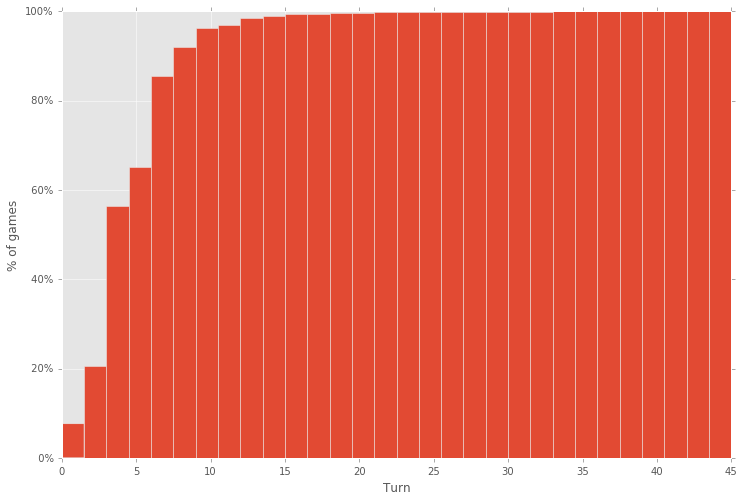

In [6]:
fig, ax = plt.subplots(figsize=(12, 8))
pd.DataFrame(df.turns).hist(bins=30, figsize=(12, 8), ax=ax, normed=True, cumulative=True)
matplotlib.style.use('ggplot')

ax.set_xlabel("Turn")
ax.set_ylabel("% of games")
ax.set_title('')

vals = ax.get_yticks()
ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])

In [7]:
#hist, edges = np.histogram(df.turns, bins=100, density=True)
x = (df.turns.value_counts() / len(df.turns)).sort_index()
x
pd.options.display.max_rows = 100
x.cumsum()

0.0     0.054308
1.0     0.076189
2.0     0.206602
3.0     0.282853
4.0     0.563522
5.0     0.651171
6.0     0.821041
7.0     0.854174
8.0     0.919589
9.0     0.934045
10.0    0.963330
11.0    0.969258
12.0    0.981988
13.0    0.984380
14.0    0.989767
15.0    0.991139
16.0    0.993490
17.0    0.994114
18.0    0.995861
19.0    0.996256
20.0    0.997109
21.0    0.997379
22.0    0.997941
23.0    0.998045
24.0    0.998357
25.0    0.998440
26.0    0.998960
27.0    0.999147
28.0    0.999376
29.0    0.999438
30.0    0.999584
31.0    0.999605
32.0    0.999750
34.0    0.999813
36.0    0.999896
38.0    0.999938
40.0    0.999958
45.0    1.000000
Name: turns, dtype: float64

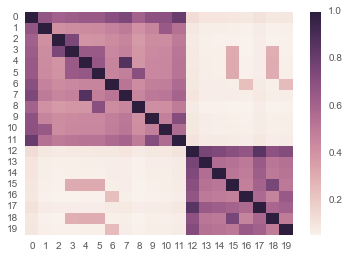

In [322]:
from  sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.cluster import DBSCAN
from sklearn import covariance

# Group decks together based on cards
decks1 = raw_df.dropna()[['deck1', 'hero1']].copy()
decks1.columns = ['deck', 'hero']
decks2 = raw_df[['deck2', 'hero2']].copy()
decks2['deck2'] = decks2['deck2'].str.strip()
decks2 = decks2.replace('', np.nan).dropna()

decks2.columns = ['deck', 'hero']
decks = pd.concat([decks1, decks2]).dropna()
decks['card_count'] = decks['deck'].apply(card_count)



decks['hero'] = decks['hero'].apply(card_class)
deck_groups = decks.groupby(['deck', 'hero', 'card_count']).size()

deck_groups = deck_groups.T.reset_index()
pd.options.display.max_rows = 500


d = [dict({k: row[0] for k in row['deck'].split('|')}, **{row['hero']: row[0]}) for _, row in deck_groups.iterrows()]

hasher = DictVectorizer(sparse=False)
X = hasher.fit_transform(d)

tfid = TfidfTransformer(sublinear_tf=False)
X = tfid.fit_transform(X)

#decks

#decks
#raw_df.tail()
from sklearn.metrics.pairwise import cosine_similarity
sim = cosine_similarity(X)

f = sim[:20, :20]
import seaborn as sns
sns.heatmap(f)

#d[2], d[4]
#edge_model = covariance.GraphLassoCV()

# standardize the time series: using correlations rather than covariance
# is more efficient for structure recovery
#X = variation.copy().T
#X /= X.std(axis=0)


#edge_model.fit()

#edge_model.covariance_
###############################################################################
# Cluster using affinity propagation

#_, labels = cluster.affinity_propagation(edge_model.covariance_)
#n_labels = labels.max()

#hasher.inverse_transform(tfid.inverse_transform(ex))

In [337]:
full_decks = deck_groups[deck_groups['card_count'] == 3]
partials = deck_groups[deck_groups['card_count'].isin([1, 2])]

for which in range(len(partials)):
#    which = 3
    if deck_key(partials.iloc[which].deck) == 'Innervate':

        idx = partials.iloc[which].name
        best_match = full_decks.index[np.argmax(np.take(sim[idx], full_decks.index.values))]
        print(np.max(np.take(sim[idx], full_decks.index.values)))
        
        ind = full_decks.index.values
    #    print(sim[idx][ind] > 0.6)
        matches = ind[sim[idx][ind] > 0.5]
        for best_match, val in zip(matches, sim[idx][matches]):
            print(deck_groups.loc[best_match].hero, ':', deck_key(deck_groups.loc[best_match].deck), val)
        #print(partials.iloc[which].hero, ':', deck_key(partials.iloc[which].deck),
        #               ' --> ', deck_groups.loc[best_match].hero, ':', deck_key(deck_groups.loc[best_match].deck))
    #print(list(zip(sim[idx], range(len(sim[idx])))))
    #full_decks


0.640292543797
DRUID : Innervate | Living Roots | Prince Malchezaar 0.546600799019
DRUID : Innervate | Living Roots | Y'Shaarj, Rage Unbound 0.501425288222
DRUID : Innervate | Living Roots | Yogg-Saron, Hope's End 0.501699661198
DRUID : Astral Communion | Coldlight Oracle | Innervate 0.521629435159
DRUID : Astral Communion | Innervate | Prince Malchezaar 0.547326794102
DRUID : Astral Communion | Innervate | Y'Shaarj, Rage Unbound 0.501985567352
DRUID : Astral Communion | Innervate | Yogg-Saron, Hope's End 0.502260861592
DRUID : Coldlight Oracle | Emperor Thaurissan | Innervate 0.503058572373
DRUID : Emperor Thaurissan | Innervate | Prince Malchezaar 0.525987511616
DRUID : Coldlight Oracle | Goldshire Footman | Innervate 0.507674871634
DRUID : Claw | Coldlight Oracle | Innervate 0.502069628192
DRUID : Claw | Innervate | Prince Malchezaar 0.524857395385
DRUID : Healing Touch | Innervate | Prince Malchezaar 0.510245692378
DRUID : Innervate | Moonfire | Prince Malchezaar 0.527091623761
DRU

In [82]:
dbs = DBSCAN(eps=0.75, min_samples=2).fit(X)
core_samples_mask = np.zeros_like(dbs.labels_, dtype=bool)
core_samples_mask[dbs.core_sample_indices_] = True
labels = dbs.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_clusters_, list(labels)

d[:15]
db['EX1_287']
#dbs.labels_

<EX1_287: 'Counterspell'>

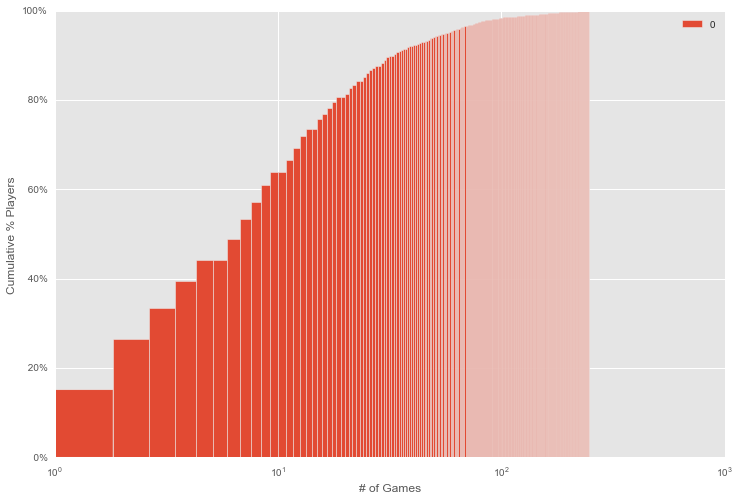

In [177]:
games = pd.read_json('24XM2YH.txt')
games.describe()

fig, ax = plt.subplots(figsize=(12, 8))
matplotlib.style.use('ggplot')

games.plot.hist(bins=300, ax=ax, cumulative=True, logx = True, normed=True)

ax.set_xlabel("# of Games")
ax.set_ylabel("Cumulative % Players")
ax.set_title('')

vals = ax.get_yticks()
ax.set_yticklabels(['{:3.0f}%'.format(x*100) for x in vals])